L'effet des paramètres de la règle d'apprentissage STDP
=============================================

GEI723, département de génie électrique et génie informatique

Copyright (c) Automne 2019 - Automne 2020 NECOTIS, Université de Sherbrooke

Professeur: Jean Rouat

Auteurs: Ismaël Balafrej, Ahmad El Ferdaoussi

In [2]:
from brian2 import *
prefs.codegen.target = "numpy" # By using numpy, the simulation will be faster to simulate small networks
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

Le tutorial de Brian2 sur les synapses a une partie sur la STDP ici: https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html

Le tutoriel dans le lien ci-dessus explique les raisons pour lesquelles implémenter la STDP sous sa forme «classique» serait non seulement inefficace d'un point de vue computationnel, mais aussi non réaliste d'un point de vue physiologique.

Il existe une façon plus efficace et plus plausible physiologiquement pour implémenter la STDP. On va l'explorer dans ce notebook.

### Traces synaptiques
Dans cette implémentation, on définit deux variables pour une synapse: $a_{pre}$ et $a_{post}$ qui ont une évolution dans le temps semblable au potentiel d'un neurone LIF. Ces variables constituent des «traces» de décharges pré- et post-synaptiques.

$$
    \frac{d(a_{pre})}{dt} = \frac{-a_{pre}}{\tau_{pre}} \\
    \frac{d(a_{post})}{dt} = \frac{-a_{post}}{\tau_{post}} \\
$$

Qu'est-ce qui arrive aux variables $a_{pre}$ et $a_{post}$ lors d'une décharge?

* Décharge pré-synaptique: $a_{pre} \rightarrow a_{pre} + A_{pre}$
* Décharge post-synaptique: une constante $a_{post} \rightarrow a{post} + A_{post}$

Qu'est-ce qui arrive au poids de la synapse $w$ lors d'une décharge?
* Décharge pré-synaptique: $w \rightarrow w + a_{post}$
* Décharge post-synaptique: $w \rightarrow w + a_{pre}$

### Résolution des équations
Résolvons les équations différentielles pour pouvoir visualiser l'effet de la STDP sous forme graphique. On fait le calcul pour uniquement pour $a_{pre}$ puisque les équations différentielles sont identiques.

On peut réécrire l'équation différentielle sous la forme:

$$
\tau_{pre}\frac{d(a_{pre})}{a_{pre}dt} = -1
$$

et intégrer dans le temps depuis $t_{pre}$, l'instant d'une décharge pré-synaptique, jusqu'à $t_{post}$, l'instant d'une décharge post-synaptique:

$$
\tau_{pre} \int_{t_{pre}}^{t_{post}} \frac{d(a_{pre})}{a_{pre}dt} dt = \int_{t_{pre}}^{t_{post}} -1 dt
$$

qui donne:

$$
\tau_{pre} (ln(a_{pre}(t_{post}) - ln(a_{pre}(t_{pre})) = -(t_{post}-t_{pre})
$$

ou encore, avec $\Delta t = t_{post} - t_{pre}$:

$$
ln \left( \frac{a_{pre}(t_{post})}{a_{pre}(t_{pre})} \right) = \frac{-\Delta t}{\tau_{pre}}
$$

et enfin:

$$
a_{pre}(t_{post}) = a_{pre}(t_{pre})e^{\frac{-\Delta t}{\tau_{pre}}}
$$

Supposons qu'à l'arrivée de la décharge pré-synaptique, $a_{pre}$ était à zéro, donc $a_{pre}(t_{pre_+}) = A_{pre}$ après la décharge pré-synaptique.

Notre équation devient

$$
a_{pre}(t_{post}) = A_{pre} e^{\frac{-\Delta t}{\tau_{pre}}}
$$

Le calcul est analogue pour $a_{post}$.

### Graphique
La différence du poids synaptique $\Delta w$ dépend de $\Delta t = t_{post} - t_{pre}$.
* Si $\Delta t > 0$: $\Delta w = a_{pre}$
* Si $\Delta t < 0$: $\Delta w = a_{post}$

Dessinons le graphique de $\Delta w$ en fonction de $\Delta t$.

Note: ici on a fait l'hypothèse que les traces synaptiques étaient à zéro avant l'arrivée des décharges, et qu'il n'y a qu'une seule paire de décharges qui arrive: une pré-synaptique et une post-synaptique. Que se passe-t-il avec des patrons de décharges plus complexes?

In [15]:
# Delta t est la différence entre les instants de décharge post- et pré-synaptiques.
deltat = np.linspace(-50, 50, num=5000)

# Notre fonction 
def f(taupre=20., taupost=20., Apre=0.01, Apost=-0.01):
    
    plt.figure(figsize=(8,5))
    
    # Initialisons le vecteur Delta w
    deltaw = np.zeros(deltat.shape)
    # Pour Delta t positif, Delta w = a_pre
    deltaw[deltat > 0] = Apre*np.exp(-deltat[deltat > 0]/taupre)
    # Pour Delta t négatif, Delta w = a_post
    deltaw[deltat < 0] = Apost*np.exp(deltat[deltat < 0]/taupost)
    
    # Dessinons le graphique
    plt.plot(deltat, deltaw)
    plt.title('STDP paramétrisée')
    plt.xlabel('Δt')
    plt.ylabel('Δw')
    plt.axhline(y=0, color='black')
    plt.ylim(min(Apre, Apost, 0), max(Apre, Apost, 0))
    plt.grid()

# Jupyter permet d'avoir des graphiques interactifs dans lesquels
# on peut changer les valeurs des variables de façon dynamique.
interactive(f, 
   taupre=(0.01, 50.0, 0.01), 
   taupost=(0.01, 50.0, 0.01), 
   Apre=(0, 0.5, 0.01), 
   Apost=(-0.5, 0, 0.01))

interactive(children=(FloatSlider(value=20.0, description='taupre', max=50.0, min=0.01, step=0.01), FloatSlide…

### Traces synaptiques avec Brian2

Implémentons à présent cette formulation de la STDP sous Brian2.

On peut bien sûr utiliser directement les équations différentielles avec Brian2.

On va simuler deux neurones qui ont une connexion synaptique avec la STDP. On fait en sorte que ces neurones déchargent à des différences de temps $\Delta t$ différentes, et on observe le changement de poids $\Delta w$ qui s'opère dans la synapse en fonction de la différence entre les instants de décharge.

Pour éviter toute confusion entre la syntaxe $a_{pre}$, $a_{post}$, et les mots-clés "pre" et "post" que Brian2 utilise pour distinguer les variables des neurones pré- et post-synaptiques, on va renommer ces variables respectivement $a$ et $b$ (et de même pour les autres variables).

Note: remarquez le mot-clé "(event-driven)" ajouté aux variables des traces synaptiques. Brian2 travaille avec une horloge et fait (normalement) les mises à jour des variables à chaque pas de l'horloge. Ceci n'est pas efficace pour nos variables de traces synaptiques, dont on n'a besoin que lorsqu'il y a une décharge. On peut demander à Brian2 de ne les mettre à jour qu'à l'arrivée d'un évènement (c'est-à-dire une décharge) avec "(event-driven)". Plus de détails ici: https://brian2.readthedocs.io/en/stable/user/synapses.html?highlight=event-driven#event-driven-updates

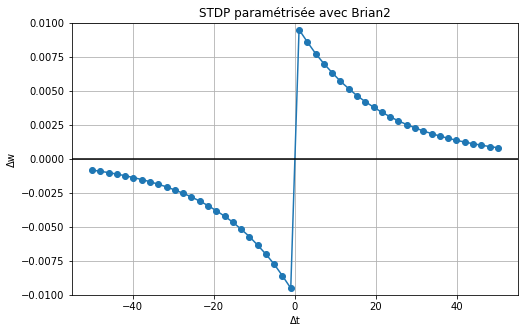

In [14]:
start_scope()

# Création des neurones
tau = 10*ms
eqs_neuron = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(2, model=eqs_neuron, threshold='v>1', reset='v=0', method='euler')

# Création des synapses
tau_a = tau_b = 20*ms
A = 0.01
B = -A

eqs_stdp = '''
    w : 1
    da/dt = -a / tau_a : 1 (event-driven) 
    db/dt = -b / tau_b : 1 (event-driven)
'''
on_pre = '''
    v_post += w
    a += A
    w = w + b
'''
on_post = '''
    b += B
    w = w + a
'''

S = Synapses(G, G, model=eqs_stdp, on_pre=on_pre, on_post=on_post, method='euler')

# Création d'une connexion synaptique
S.connect(i=0, j=1)

# Générons maintenant des entrées pour nos neurones
input_generator = SpikeGeneratorGroup(2, [], []*ms) # Our input layer consist of 2 neurons
# Connectons ce générateur à nos deux neurones
input_generator_synapses = Synapses(input_generator, G, on_pre='v_post += 2') # Forcer des décharges
input_generator_synapses.connect(i=[0, 1], j=[0, 1]) 

# Faisons la simulation pour différents Delta t et calculons Delta w.
deltat = np.linspace(-50, 50, num=50)
deltaw = np.zeros(deltat.size) # Vecteur pour les valeurs de Delta w

# On utilise store() et restore() pour faire cette simulation, comme expliqué dans le notebook sur Brian2!
store()

for i in range(deltat.size):
    dt = deltat[i]
    
    restore()
    
    # On fait en sorte que les neurones déchargent à 0 ms et à |dt| ms
    # En fonction du signe de dt, les neurones vont décharger un avant l'autre
    if dt < 0:
        input_generator.set_spikes([0, 1], [-dt, 0]*ms) 
    else:
        input_generator.set_spikes([0, 1], [0, dt]*ms)
    run((np.abs(dt)+1)*ms)
    deltaw[i] = S.w[0] # delta w est tout simplement w ici parce que w est à zéro initialement

# Faisons le graphique de dw en fonction de dt 
plt.figure(figsize=(8,5))
plt.plot(deltat, deltaw, linestyle='-', marker='o')
plt.title('STDP paramétrisée avec Brian2')
plt.xlabel('Δt')
plt.ylabel('Δw')
axhline(y=0, color='black')
plt.ylim(min(A, B), max(A, B))
plt.grid()

### Formulation classique

Implémentons à présent la formulation «classique» de la STDP, mais en tenant compte uniquement de la dernière paire de décharges pré- et post-synaptiques.

$$
\Delta w = W(t_{post}-t_{pre})
$$

$$
\begin{split}W(\Delta t) = \begin{cases}
A_{pre} e^{-\Delta t/\tau_{pre}} & \Delta t>0 \\
A_{post} e^{\Delta t/\tau_{post}} & \Delta t<0
\end{cases}\end{split}
$$

À chaque fois que le neurone pré-synaptique décharge, on enregistre l'instant de décharge dans une variable. Cette variable ne garde mémoire que de la dernière décharge pré-synaptique.

On fait de même pour le neurone post-synaptique.

Lorsqu'on enregistre deux décharges pré- et post-synaptiques, on effectue le changement de poids et on réinitalise la variable de celle la plus ancienne.

Comme fait avant, on va remplacer la syntaxe $A_{pre}$, $A_{post}$ par $A$, $B$, respectivement, pour éviter toute confusion avec les mots-clés "_pre" et "_post" de Brian2 (et de même pour $\tau$).

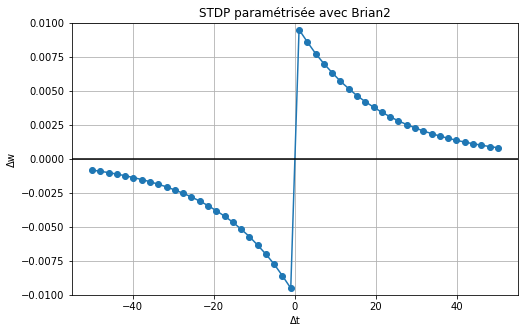

In [11]:
start_scope()

tau = 10*ms
eqs_neuron = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(2, model=eqs_neuron, threshold='v>1', reset='v=0', method='euler')
tau_a = tau_b = 20*ms
A = 0.01
B = -A

# Cette variable nous permet de réinitialiser les instants de décharge après que la STDP s'opère dans la synapse
# On va utiliser la condition int(t_spike_a > t0) pour évaluer si oui ou non on opère le changement de poids
t0 = 0*second

eqs_stdp = '''
    w : 1
    t_spike_a : second 
    t_spike_b : second
'''
# On peut avoir accès au temps avec la variable t dans la syntaxe des équations de Brian2
on_pre = '''
    v_post += w
    t_spike_a = t
    w = w + int(t_spike_b > t0) * B * exp((t_spike_b - t_spike_a)/tau_b)      # le cas Delta t < 0
    t_spike_b = t0
'''
on_post = '''
    t_spike_b = t
    w = w +  int(t_spike_a > t0) * A * exp(-(t_spike_b - t_spike_a)/tau_a)    # le cas Delta t > 0
    t_spike_a = t0
'''

############################################################
####### Ci-dessous exactement le même code qu'avant! #######
############################################################

S = Synapses(G, G, model=eqs_stdp, on_pre=on_pre, on_post=on_post, method='euler')

# Création d'une connexion synaptique
S.connect(i=0, j=1)

# Générons maintenant des entrées pour nos neurones
input_generator = SpikeGeneratorGroup(2, [], []*ms) # Our input layer consist of 2 neurons
# Connectons ce générateur à nos deux neurones
input_generator_synapses = Synapses(input_generator, G, on_pre='v_post += 2') # Forcer des décharges
input_generator_synapses.connect(i=[0, 1], j=[0, 1]) 

# Faisons la simulation pour différents Delta t et calculons Delta w.
deltat = np.linspace(-50, 50, num=50)
deltaw = np.zeros(deltat.size) # Vecteur pour les valeurs de Delta w

store()

for i in range(deltat.size):
    dt = deltat[i]
    
    restore()
    
    # On fait en sorte que les neurones déchargent à 0 ms et à |dt| ms
    # En fonction du signe de dt, les neurones vont décharger un avant l'autre
    if dt < 0:
        input_generator.set_spikes([0, 1], [-dt, 0]*ms) 
    else:
        input_generator.set_spikes([0, 1], [0, dt]*ms)
    run((np.abs(dt)+1)*ms)
    deltaw[i] = S.w[0] # delta w est tout simplement w ici parce que w est à zéro initialement

# Faisons le graphique de dw en fonction de dt 
plt.figure(figsize=(8,5))
plt.plot(deltat, deltaw, linestyle='-', marker='o')
plt.title('STDP paramétrisée avec Brian2')
plt.xlabel('Δt')
plt.ylabel('Δw')
axhline(y=0, color='black')
plt.ylim(min(A, B), max(A, B))
plt.grid()

### Et la différence?

Considérons le train de décharge suivant au niveau de la synapse: (pre, pre, post).

Que se passe-t-il avec la deuxième formulation de la STDP, et quelle est la différence avec la méthode des traces synaptiques?